# BNFinder Analysis Summary

This notebook summarizes the results of the BNFinder experiments, identifying how different dataset parameters affect network recovery and attractor identification, separated by network dimensionality.

In [17]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import glob
import os

# Set plot style
sns.set_theme(style="whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)

In [18]:
# Load data
report_files = glob.glob("reports/analysis_report_*.csv")

if not report_files:
    print("No analysis reports found in reports/ directory. Generating path check...")
    # Fallback/Debug check
    if os.path.exists('analysis/reports'):
         report_files = glob.glob("analysis/reports/analysis_report_*.csv")

dfs = []
for f in report_files:
    try:
        df_temp = pd.read_csv(f)
        dfs.append(df_temp)
    except Exception as e:
        print(f"Error reading {f}: {e}")

if dfs:
    df = pd.concat(dfs, ignore_index=True)
    print(f"Loaded {len(df)} rows from {len(dfs)} reports.")
    # Ensure dim is treated as numeric
    df.sort_values(by="dim", inplace=True)
    display(df.head())
else:
    print("No data loaded.")
    df = pd.DataFrame()

Loaded 7998 rows from 15 reports.


,dim,id,mode,freq,size,len,attr_ratio,score,TP,FP,...,Recall,F1,Transition_Accuracy,Attractors_Correct,Attractors_True_Count,Attractors_Learned_Count,Attractors_Precision,Attractors_Recall,Attractors_F1,filename
0,5,4,async,1,300,100,0.8,BDE,7,7,...,0.875000,0.636364,0.09375,1,1,8,0.125000,1.0,0.222222,5d_004_async_f1_s300_l100_at0.8_scrBDE.bif
1498,5,1,sync,10,100,100,1.0,BDE,8,6,...,0.727273,0.640000,0.25000,3,3,4,0.750000,1.0,0.857143,5d_001_sync_f10_s100_l100_at1.0_scrBDE.bif
1497,5,1,sync,10,300,50,1.0,BDE,7,8,...,0.636364,0.538462,0.28125,3,3,4,0.750000,1.0,0.857143,5d_001_sync_f10_s300_l50_at1.0_scrBDE.bif
1496,5,1,sync,1,300,10,1.0,BDE,6,1,...,0.545455,0.666667,0.37500,3,3,8,0.375000,1.0,0.545455,5d_001_sync_f1_s300_l10_at1.0_scrBDE.bif
1495,5,1,async,1,10,10,0.6,BDE,3,5,...,0.272727,0.315789,0.09375,2,2,24,0.083333,1.0,0.153846,5d_001_async_f1_s10_l10_at0.6_scrBDE.bif


## 1. Overall Performance Distribution by Dimension

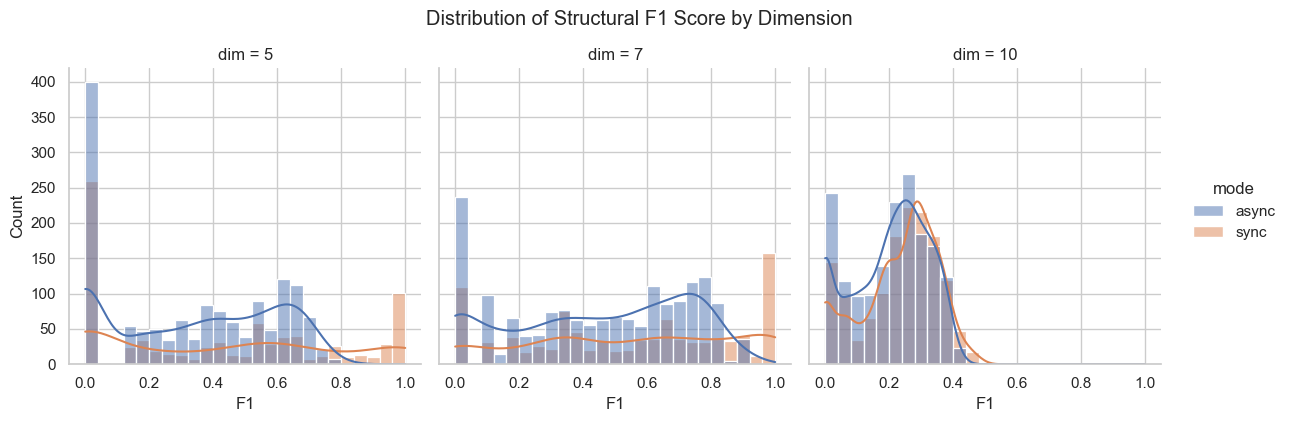

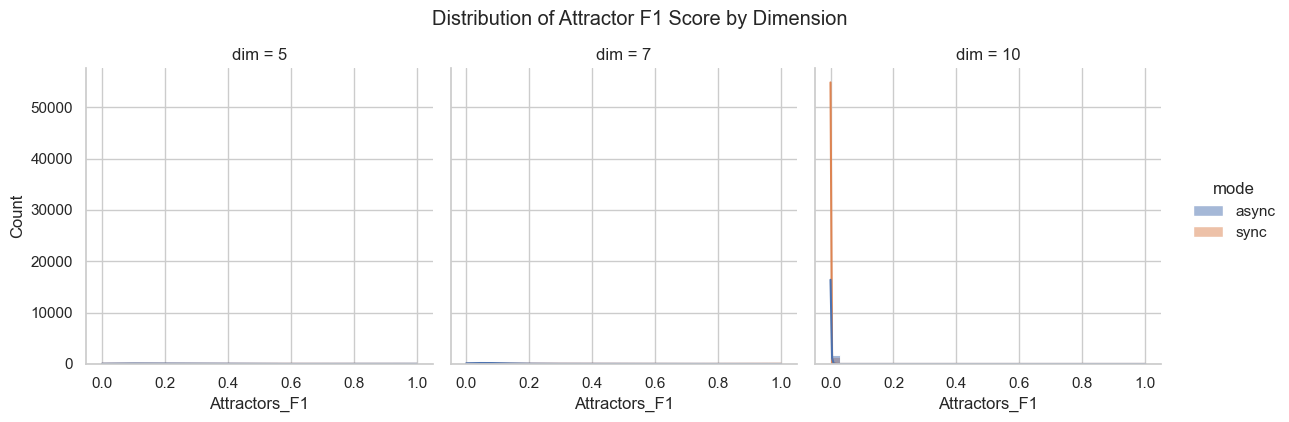

In [19]:
if not df.empty:
    # Structural F1
    g = sns.displot(data=df, x="F1", hue="mode", col="dim", kde=True, height=4, aspect=1)
    g.fig.suptitle("Distribution of Structural F1 Score by Dimension", y=1.05)
    plt.show()
    
    # Attractor F1
    if "Attractors_F1" in df.columns:
        g = sns.displot(data=df, x="Attractors_F1", hue="mode", col="dim", kde=True, height=4, aspect=1)
        g.fig.suptitle("Distribution of Attractor F1 Score by Dimension", y=1.05)
        plt.show()

## 2. Impact of Dataset Parameters

We vary `len`, `size`, `freq`, and `attr_ratio` and observe the impact on metrics, faceted by dimension (`dim`).

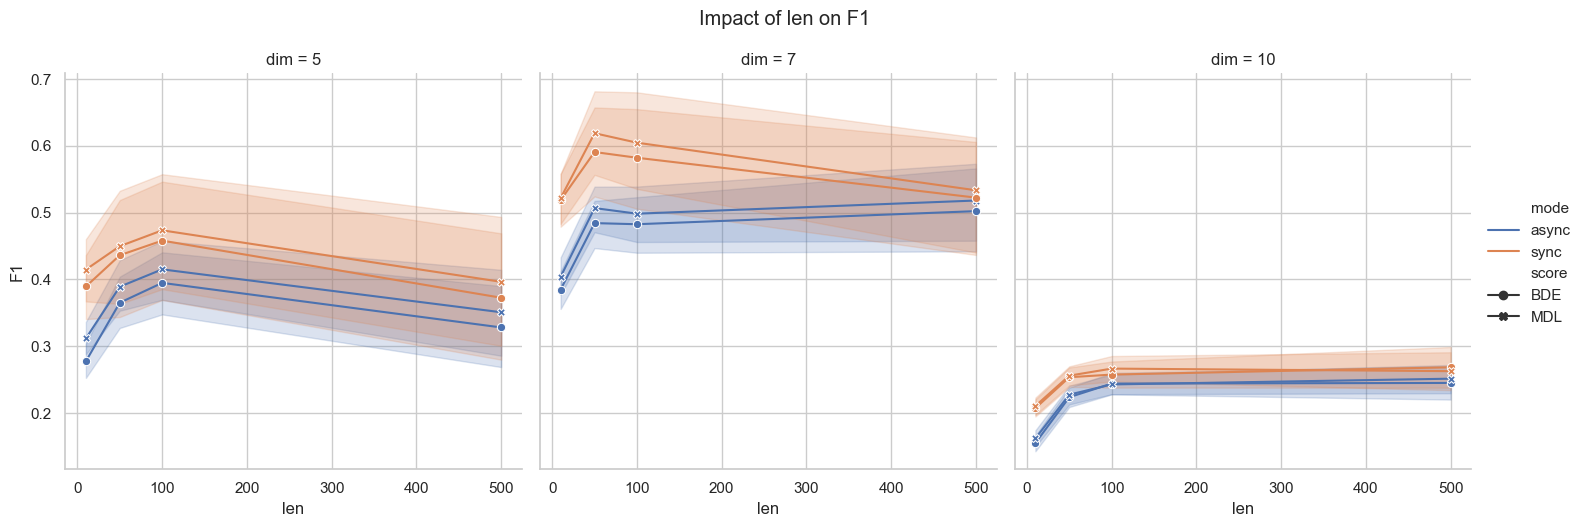

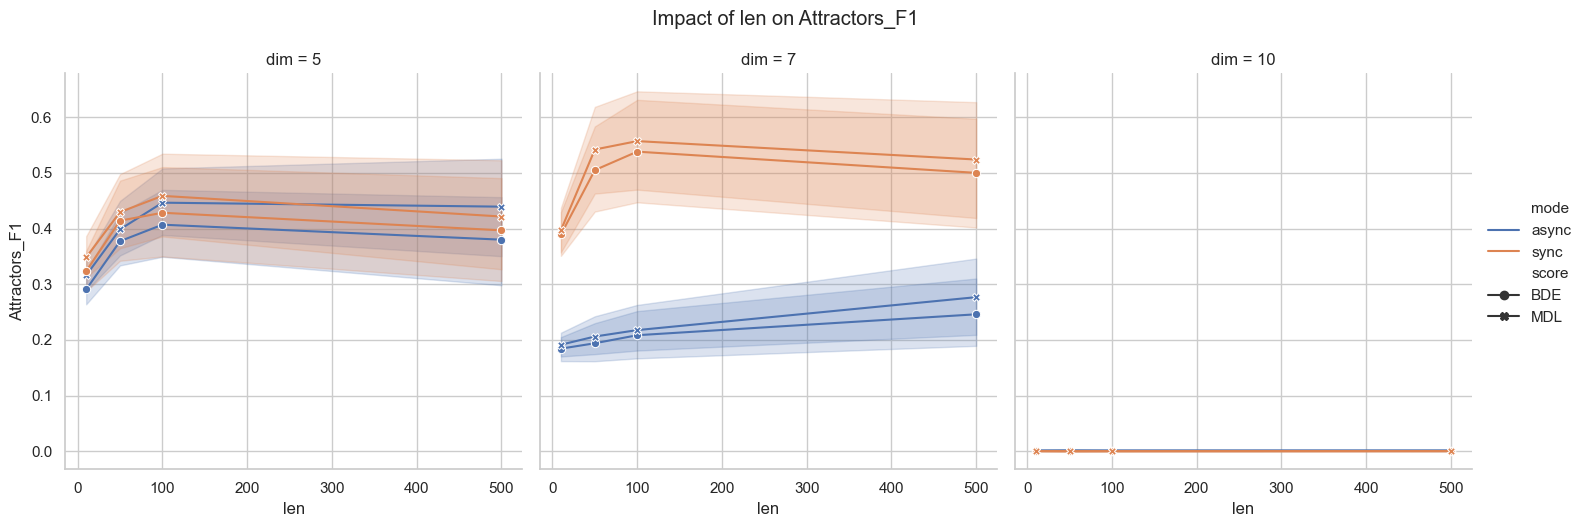

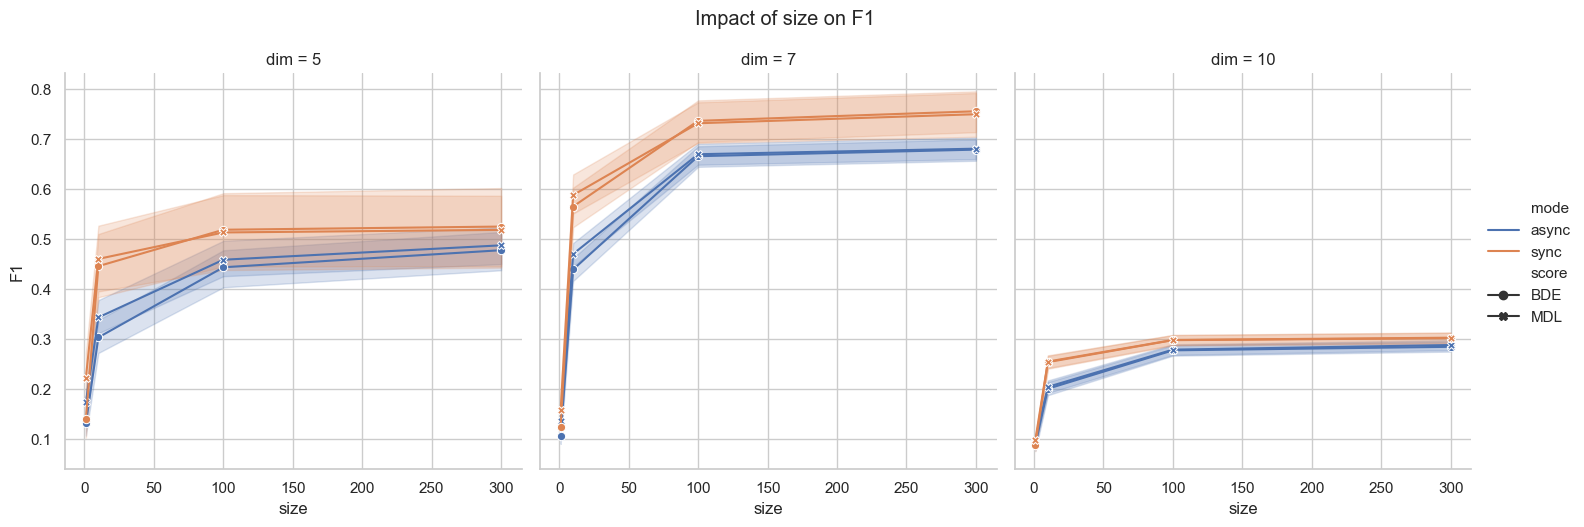

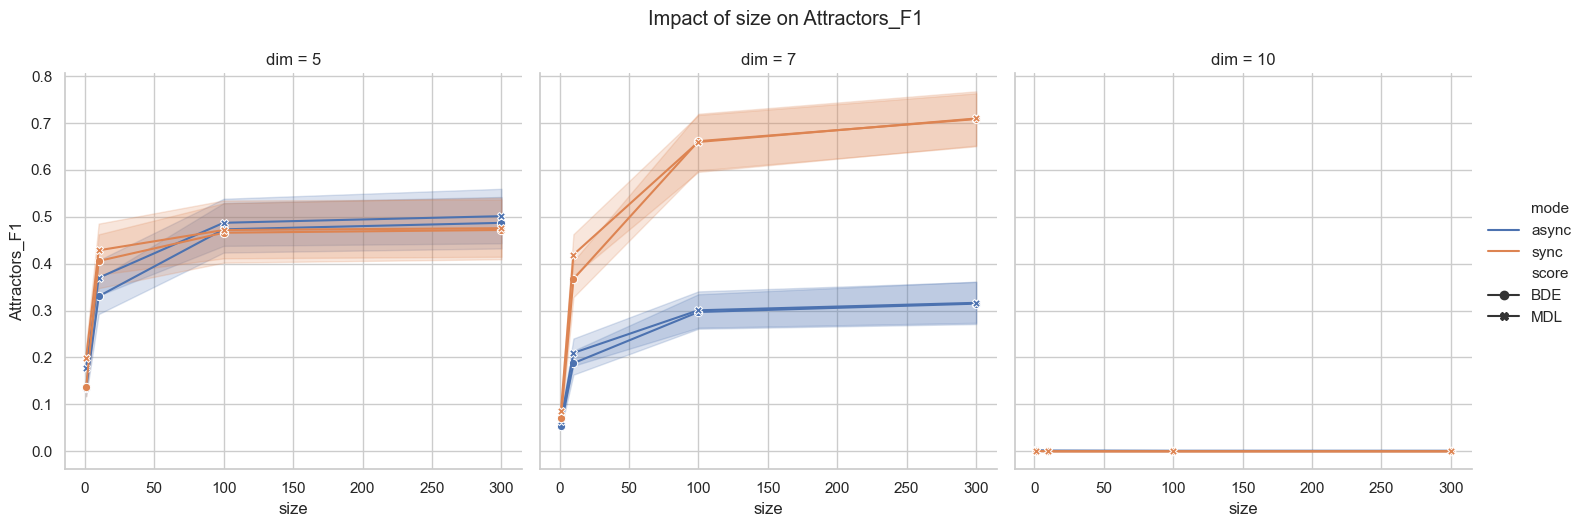

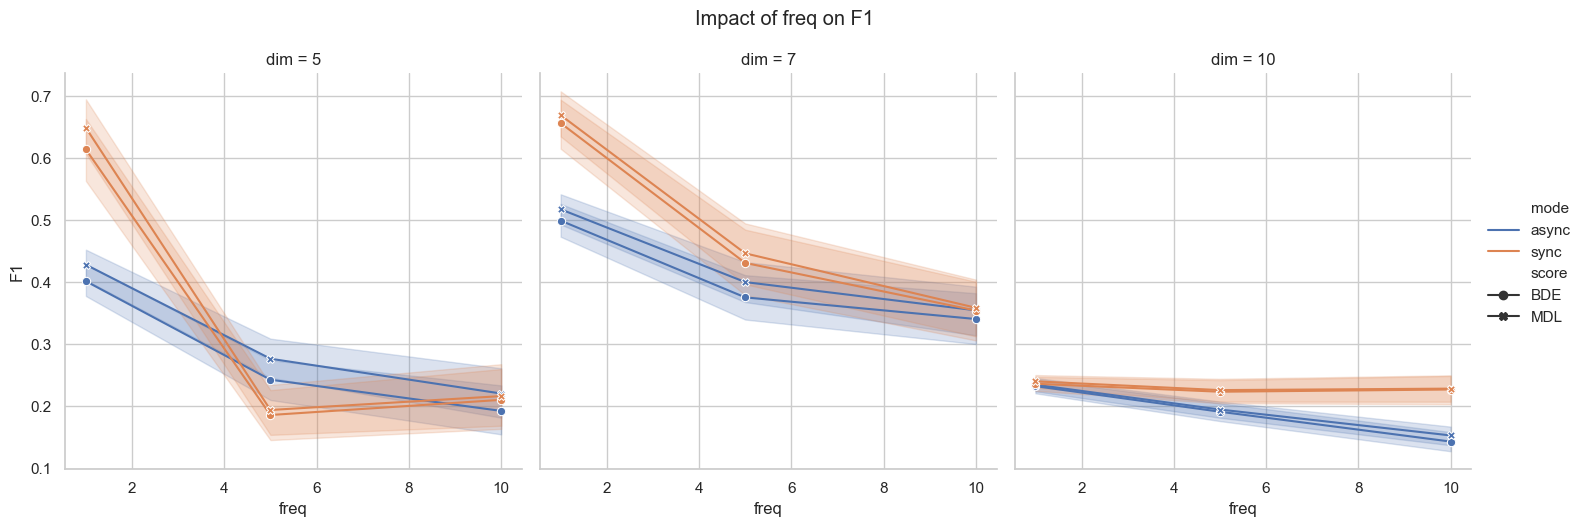

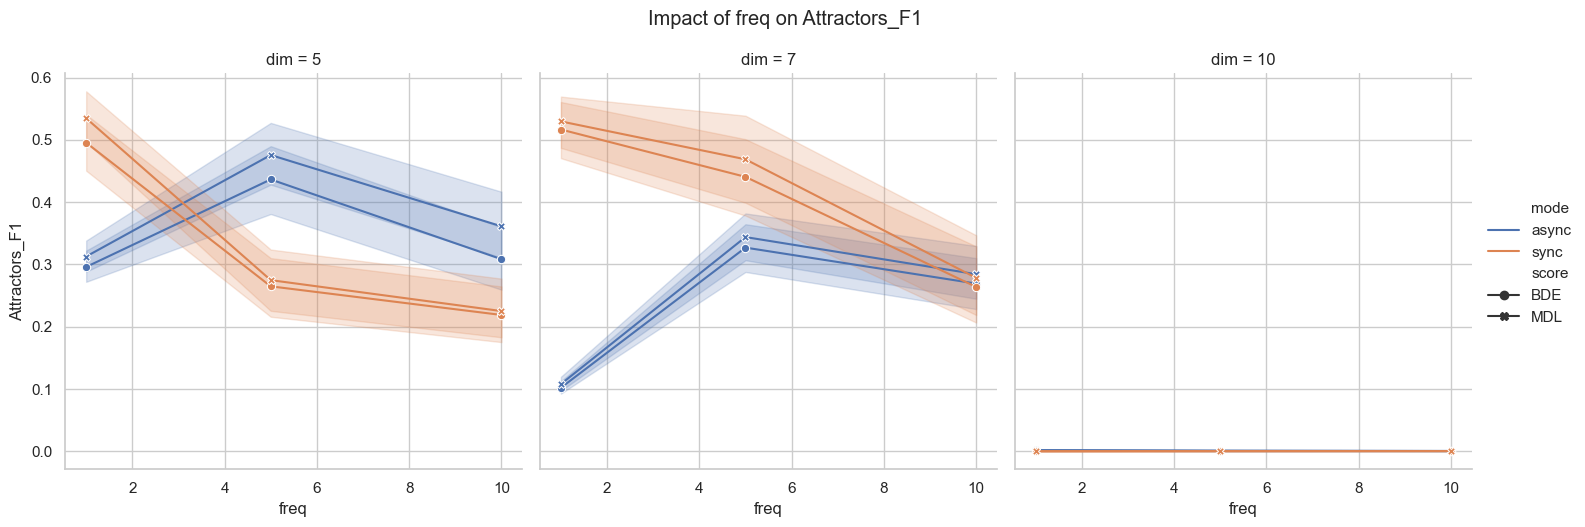

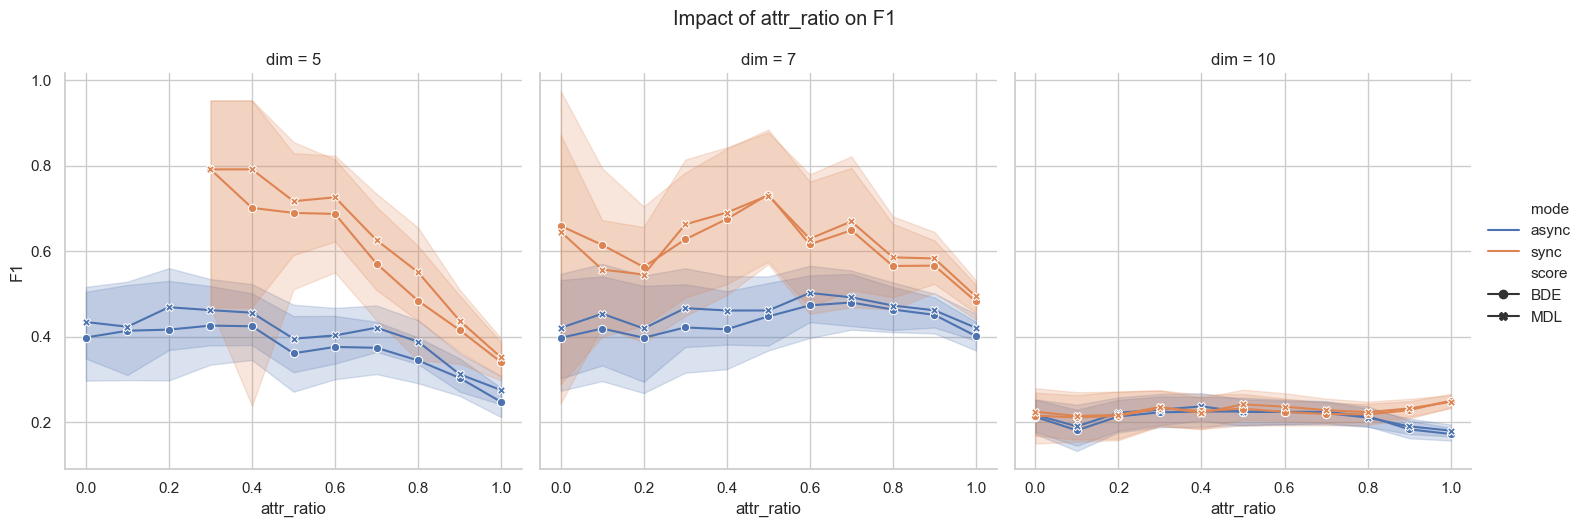

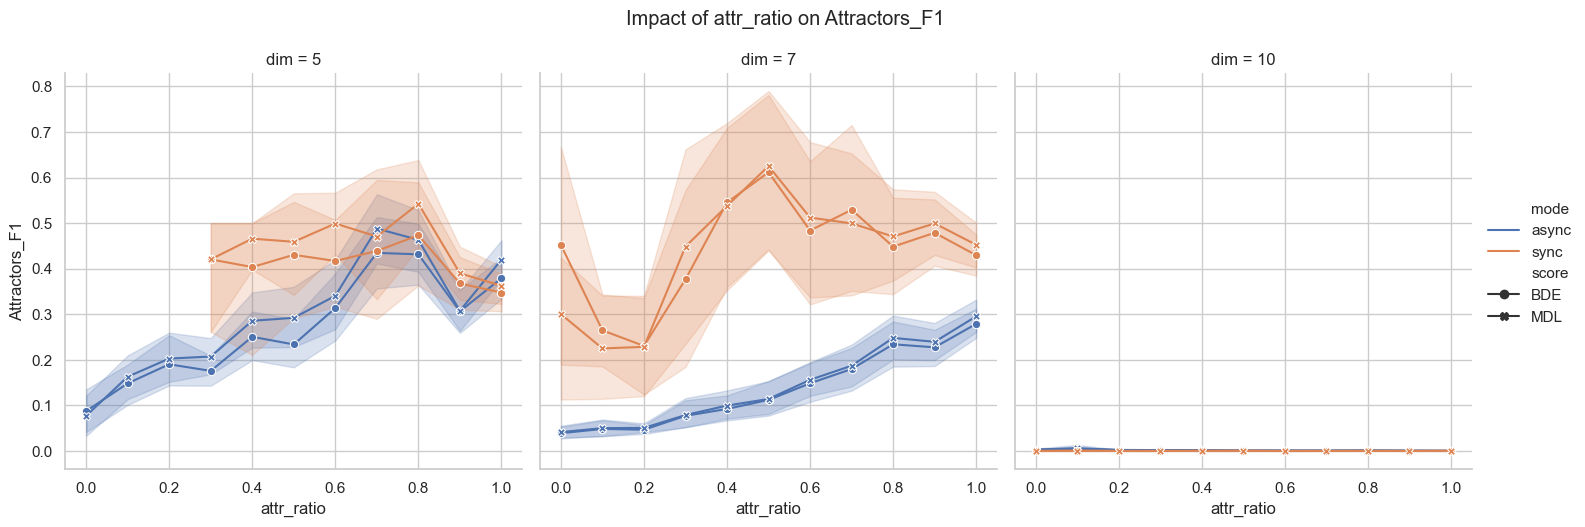

In [20]:
def plot_impact_faceted(df, x_param, y_metric, title):
    if x_param not in df.columns or y_metric not in df.columns:
        return

    # relplot allows creating subplots via 'col'
    g = sns.relplot(
        data=df, 
        x=x_param, 
        y=y_metric, 
        hue="mode", 
        style="score", 
        col="dim", 
        kind="line", 
        markers=True, 
        dashes=False,
        height=5, 
        aspect=1
    )
    g.fig.suptitle(f"{title}", y=1.05)
    plt.show()

metrics_to_plot = ["F1", "Attractors_F1"]
params = ["len", "size", "freq", "attr_ratio"]

if not df.empty:
    for param in params:
        for metric in metrics_to_plot:
            if metric in df.columns:
                plot_impact_faceted(df, param, metric, f"Impact of {param} on {metric}")

## 3. Mode Comparison (Sync vs Async) by Dimension

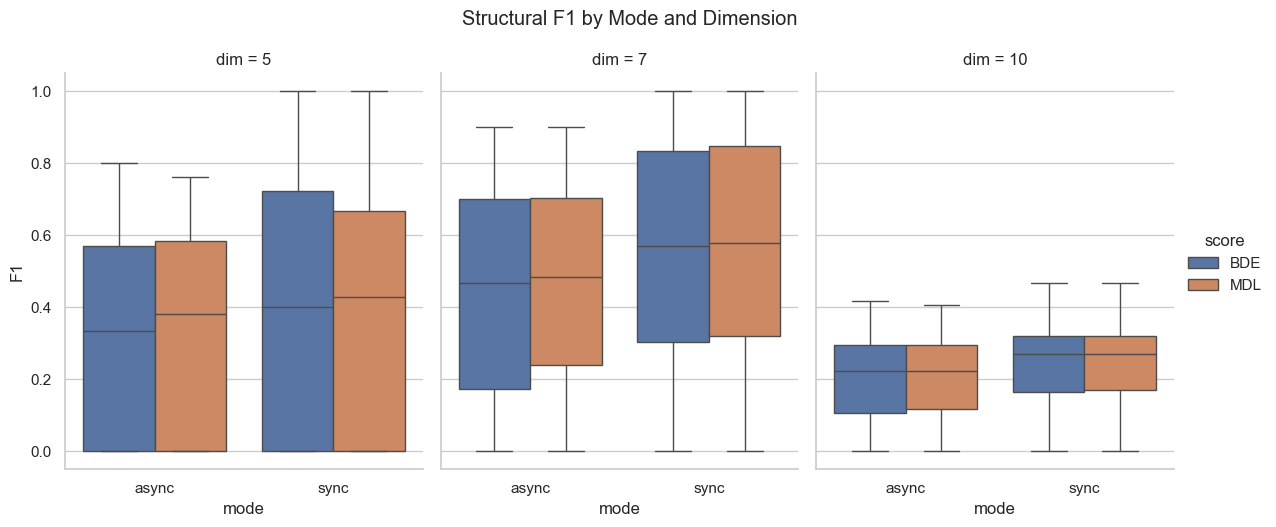

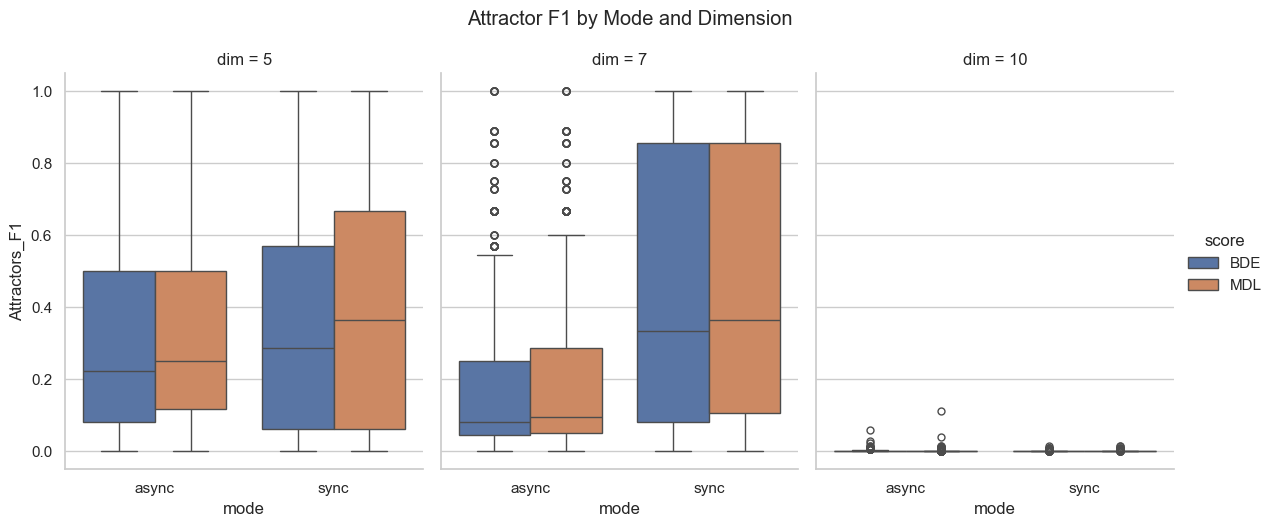

In [21]:
if not df.empty:
    # Structural F1
    g = sns.catplot(
        data=df, 
        x="mode", 
        y="F1", 
        hue="score", 
        col="dim", 
        kind="box",
        height=5, 
        aspect=0.8
    )
    g.fig.suptitle("Structural F1 by Mode and Dimension", y=1.05)
    plt.show()
    
    # Attractor F1
    if "Attractors_F1" in df.columns:
        g = sns.catplot(
            data=df, 
            x="mode", 
            y="Attractors_F1", 
            hue="score", 
            col="dim", 
            kind="box",
            height=5, 
            aspect=0.8
        )
        g.fig.suptitle("Attractor F1 by Mode and Dimension", y=1.05)
        plt.show()

## 4. Best Performing Configurations per Dimension

The following tables show the metadata for the top 3 networks in each dimension, sorted by F1 score.

In [22]:
if not df.empty:
    cols = ["filename", "mode", "score", "len", "size", "freq", "attr_ratio", "F1", "Attractors_F1"]
    
    dims = df["dim"].unique()
    for d in sorted(dims):
        print(f"\n=== Dimension {d} ===")
        dim_df = df[df["dim"] == d]
        
        print(f"  Top 3 by Structural F1 (Dim {d}):")
        display(dim_df.nlargest(3, "F1")[cols])
        
        if "Attractors_F1" in dim_df.columns:
            print(f"  Top 3 by Attractor F1 (Dim {d}):")
            display(dim_df.nlargest(3, "Attractors_F1")[cols])


=== Dimension 5 ===
  Top 3 by Structural F1 (Dim 5):


,filename,mode,score,len,size,freq,attr_ratio,F1,Attractors_F1
1486,5d_001_sync_f1_s100_l50_at1.0_scrBDE.bif,sync,BDE,50,100,1,1.0,1.0,0.857143
1402,5d_001_sync_f1_s300_l100_at1.0_scrBDE.bif,sync,BDE,100,300,1,1.0,1.0,1.000000
1411,5d_001_sync_f1_s100_l500_at1.0_scrMDL.bif,sync,MDL,500,100,1,1.0,1.0,1.000000


  Top 3 by Attractor F1 (Dim 5):


,filename,mode,score,len,size,freq,attr_ratio,F1,Attractors_F1
1492,5d_001_async_f5_s300_l50_at1.0_scrBDE.bif,async,BDE,50,300,5,1.0,0.615385,1.0
1484,5d_001_sync_f1_s10_l500_at1.0_scrBDE.bif,sync,BDE,500,10,1,1.0,0.952381,1.0
1472,5d_001_sync_f10_s100_l100_at1.0_scrMDL.bif,sync,MDL,100,100,10,1.0,0.615385,1.0



=== Dimension 7 ===
  Top 3 by Structural F1 (Dim 7):


,filename,mode,score,len,size,freq,attr_ratio,F1,Attractors_F1
4009,7d_003_sync_f1_s100_l50_at0.9_scrBDE.bif,sync,BDE,50,100,1,0.9,1.0,1.0
3979,7d_003_sync_f1_s100_l50_at0.9_scrMDL.bif,sync,MDL,50,100,1,0.9,1.0,1.0
3912,7d_003_sync_f1_s300_l10_at0.6_scrMDL.bif,sync,MDL,10,300,1,0.6,1.0,1.0


  Top 3 by Attractor F1 (Dim 7):


,filename,mode,score,len,size,freq,attr_ratio,F1,Attractors_F1
4009,7d_003_sync_f1_s100_l50_at0.9_scrBDE.bif,sync,BDE,50,100,1,0.9,1.00,1.0
3979,7d_003_sync_f1_s100_l50_at0.9_scrMDL.bif,sync,MDL,50,100,1,0.9,1.00,1.0
3990,7d_003_sync_f5_s100_l500_at1.0_scrMDL.bif,sync,MDL,500,100,5,1.0,0.65,1.0



=== Dimension 10 ===
  Top 3 by Structural F1 (Dim 10):


,filename,mode,score,len,size,freq,attr_ratio,F1,Attractors_F1
5388,10d_000_sync_f5_s300_l50_at1.0_scrBDE.bif,sync,BDE,50,300,5,1.0,0.466667,0.0
5424,10d_000_sync_f5_s300_l50_at1.0_scrMDL.bif,sync,MDL,50,300,5,1.0,0.466667,0.0
5342,10d_000_sync_f5_s100_l100_at1.0_scrMDL.bif,sync,MDL,100,100,5,1.0,0.466667,0.0


  Top 3 by Attractor F1 (Dim 10):


,filename,mode,score,len,size,freq,attr_ratio,F1,Attractors_F1
6559,10d_003_async_f5_s1_l50_at0.1_scrMDL.bif,async,MDL,50,1,5,0.1,0.000000,0.111111
6860,10d_003_async_f5_s1_l50_at0.1_scrBDE.bif,async,BDE,50,1,5,0.1,0.057143,0.058824
6008,10d_001_async_f5_s10_l10_at0.0_scrMDL.bif,async,MDL,10,10,5,0.0,0.102564,0.038462


## 5. Characteristics of Top Performers

We select the top 10% of networks (by Structural F1) across the entire dataset and visualize which parameters are most common among them. This helps identify "winning" configurations.

Analyzing Top 799 Networks (Best 10%)


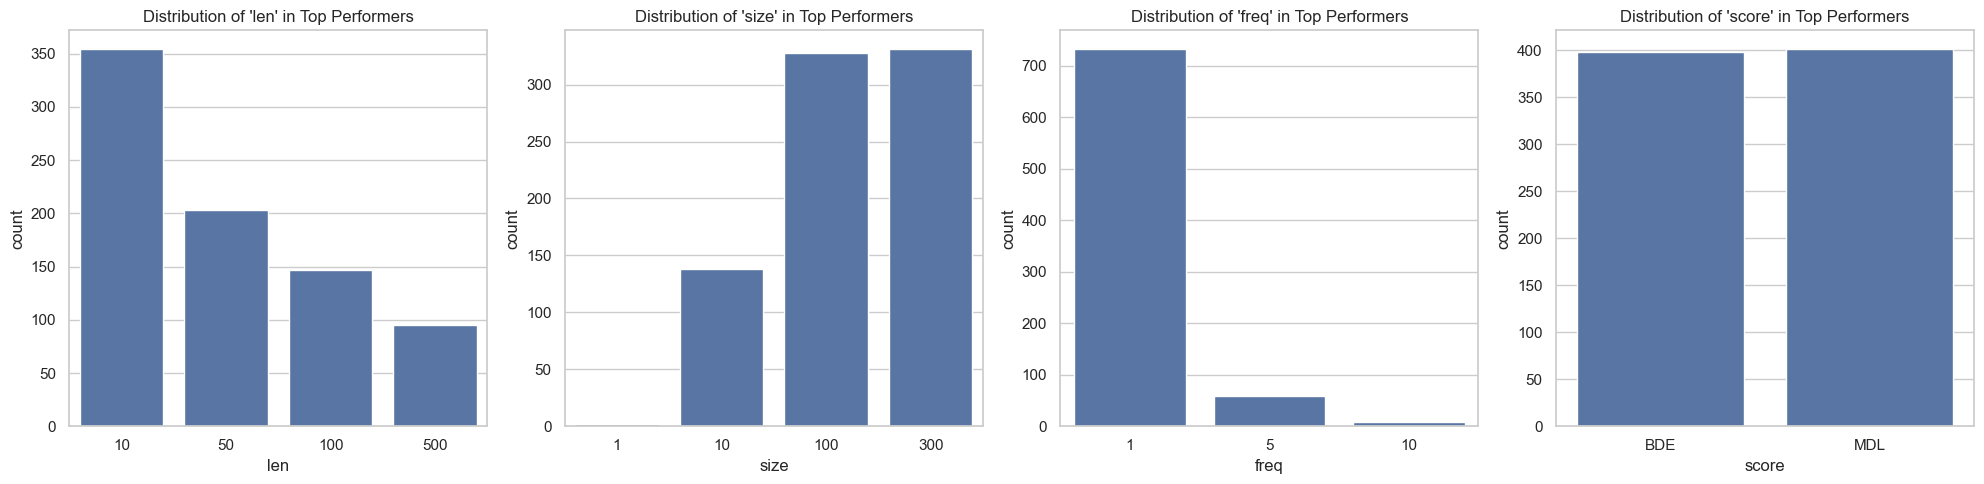

In [ ]:
# rozdziel dla sync i async
if not df.empty:
    top_fraction = 0.10
    top_n = int(len(df) * top_fraction)
    # Ensure at least some records if dataset is small
    top_n = max(top_n, 10)
    
    top_performers = df.nlargest(top_n, "F1") # to samo dla accuracy i attractors_f1
    
    print(f"Analyzing Top {len(top_performers)} Networks (Best {top_fraction*100:.0f}%)")

    fig, axes = plt.subplots(1, 4, figsize=(20, 5))
    
    # Use countplot to show frequency of parameters in the top set
    # We sort the order for clarity
    
    # Length
    sns.countplot(data=top_performers, x="len", ax=axes[0])
    axes[0].set_title("Distribution of 'len' in Top Performers")
    
    # Size
    sns.countplot(data=top_performers, x="size", ax=axes[1])
    axes[1].set_title("Distribution of 'size' in Top Performers")
    
    # Freq
    sns.countplot(data=top_performers, x="freq", ax=axes[2])
    axes[2].set_title("Distribution of 'freq' in Top Performers")
    
    # Score
    sns.countplot(data=top_performers, x="score", ax=axes[3])
    axes[3].set_title("Distribution of 'score' in Top Performers")
    
    plt.tight_layout()
    plt.show()

### Parameter Importance (Heatmap)

Average F1 score for combinations of `score` type and `mode` for each dimension.

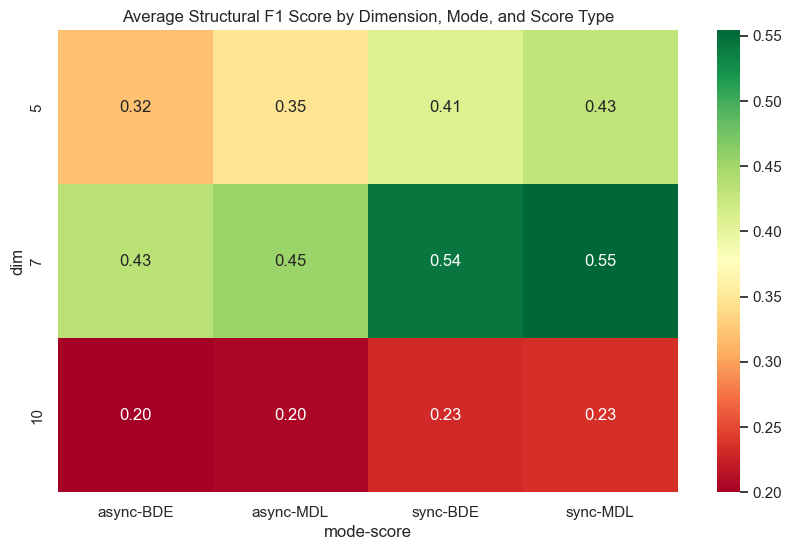

In [24]:
if not df.empty:
    # Pivot table for heatmap
    pivot = pd.pivot_table(df, values="F1", index="dim", columns=["mode", "score"], aggfunc="mean")
    
    plt.figure(figsize=(10, 6))
    sns.heatmap(pivot, annot=True, cmap="RdYlGn", fmt=".2f")
    plt.title("Average Structural F1 Score by Dimension, Mode, and Score Type")
    plt.show()